# **Autoencoder + BERT + K-Means**

# **Preparación de los datos:**

![alt text](https://github.com/AnthonyWainer/AutoencoderNLP/blob/master/images/engineering.png?raw=true "BERT")

# **Word Embedding:**

**Token Embeddings**: Se agrega un token **[CLS]** a los tokens de palabra de entrada al comienzo de la primera oración y un token **[SEP]** al final de cada oración. <br>

**Segment Embeddings**: Se agrega un marcador que indica la oración A o la oración B a cada ficha. Esto permite que el codificador distinga entre oraciones.

**Position Embeddings**: Se agrega una incrustación posicional a cada token para indicar su posición en la oración.

![alt text](https://github.com/AnthonyWainer/AutoencoderNLP/blob/master/images/Bert.png?raw=true "BERT")

# **Arquitectura:**

![alt text](https://github.com/AnthonyWainer/AutoencoderNLP/blob/master/images/model_arch.png?raw=true "architect")

## 1. Importing Libraries


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import warnings

from sklearn import svm
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight
from sklearn.utils.linear_assignment_ import linear_assignment
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve,\
 roc_auc_score, classification_report, normalized_mutual_info_score, 
 adjusted_rand_score

from tensorflow import int32
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, Layer, InputSpec
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, 
ModelCheckpoint
from tensorflow.keras import backend as K

from mlxtend.plotting import plot_confusion_matrix

warnings.filterwarnings("ignore")
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/sklearn/utils/linear_assignment_.py:22: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


In [ ]:
!wget --quiet https://raw.githubusercontent.com/AnthonyWainer/AutoencoderNLP/master/utils/cleaner.py

!pip install transformers

In [ ]:
from cleaner import processing_words
from transformers import TFBertForMaskedLM, BertTokenizer, TFBertModel
import tensorflow as tf

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 2. Loading Data

In [ ]:
dataset = pd.read_excel('https://github.com/AnthonyWainer/AutoencoderNLP/blob/master/dataset/dataset_valoration.xlsx?raw=true') 

display(dataset.sort_index().head(5))
print('\n Hay {} observaciones con {} características'.format(*dataset.shape))

,valoration,comment
0,1,totalmente satisfecho x q resolvieron mi cons...
1,1,la atencion fue rapida y clara
2,1,me atendieron bien
3,1,fue muy rapido la atencion
4,1,por que me atendieron muy amablemente con buen...



 Hay 9223 observaciones con 2 características


Text(0.5, 1.0, 'Histograma de las variables')

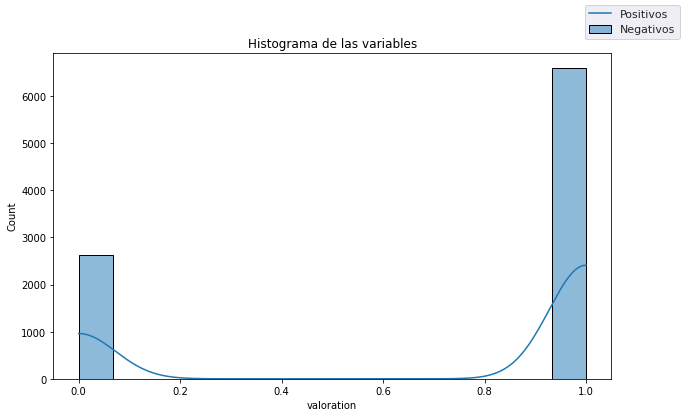

In [ ]:
fig = plt.figure(figsize=(10,6))
sns.histplot(data=dataset.valoration, kde=True, multiple="stack")
sns.set(color_codes=True)
fig.legend(labels=['Positivos','Negativos'])
plt.title("Histograma de las variables")

In [ ]:
class_weight = compute_class_weight('balanced', np.unique(dataset.valoration), dataset.valoration)

class_weight = dict(enumerate(class_weight))

class_weight

{0: 1.7547564687975648, 1: 0.6992418498862775}

## 3. Cleaning Data

In [ ]:
dataset.loc[:, ('clean_comment')] = dataset.comment.apply(processing_words)

dataset = dataset.drop_duplicates(subset='clean_comment', keep="last")

dataset.sort_index(inplace=True)

display(dataset.sort_index().head(5))
print('\n Hay {} observaciones con {} características'.format(*dataset.shape))

,valoration,comment,clean_comment
0,1,totalmente satisfecho x q resolvieron mi cons...,totalmente satisfecho resolvieron consulta ate...
4,1,por que me atendieron muy amablemente con buen...,atendieron amablemente buena actitud plataform...
5,1,me atendieron bien con mucha atencion,atendieron bien mucha atencion
6,1,la atencion de las señoritas de la entrada fue...,atencion señoritas entrada buena momento supie...
7,1,porque hay varios cajerosas es una agencia rel...,varios cajerosas agencia relativamente grande



 Hay 7391 observaciones con 3 características


## 4. BERT - BETO: Model

In [ ]:
tokenizer = BertTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased", do_lower_case=False)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForMaskedLM: ['cls.predictions.decoder.bias', 'bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForMaskedLM from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForMaskedLM from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertForMaskedLM were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.


In [ ]:
max_len = 256 # max sequence length

In [ ]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

### 4.1. Bert Encode

In [ ]:
X_ = dataset.clean_comment
Y_ = tf.keras.utils.to_categorical(np.array(dataset.valoration.to_list()), num_classes=2)

In [ ]:
# To BERT vector
X = bert_encode(X_.values, tokenizer, max_len = max_len)
Y = Y_

### 4.2. Testing BERT - BETO Model

In [ ]:
def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=int32, name="segment_ids")

    sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output["pooler_output"]
    net = Dense(256, activation='relu')(clf_output)
    net = Dense(64, activation='sigmoid')(net)
    net = Dropout(0.2)(net)
    net = Dense(32, activation='sigmoid')(net)
    net = Dropout(0.2)(net)
    out = Dense(2, activation='softmax')(net)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model  

In [ ]:
bert_layer = TFBertModel.from_pretrained(
           "dccuchile/bert-base-spanish-wwm-uncased", trainable=True, name=f"beto_module"
)

model = build_model(bert_layer, max_len=max_len)
model.summary()

Some layers from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 256)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 256)]        0                                            
__________________________________________________________________________________________________
beto_module (TFBertModel)       TFBaseModelOutputWit 109850880   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [ ]:
history = model.fit(
    X, Y,
    epochs=3,
    batch_size=32,
    class_weight = class_weight,
    verbose=1
)

Epoch 1/3
231/231 [==============================] - 396s 2s/step - loss: 0.5321 - accuracy: 0.7828
Epoch 2/3
231/231 [==============================] - 379s 2s/step - loss: 0.4163 - accuracy: 0.8872
Epoch 3/3
231/231 [==============================] - 379s 2s/step - loss: 0.3644 - accuracy: 0.9138


In [ ]:
results = model.evaluate(X, Y)
print("_"*100)
print("Test Loss and Accuracy")
print("results ", results)

231/231 [==============================] - 136s 575ms/step - loss: 0.2940 - accuracy: 0.9463
____________________________________________________________________________________________________
Test Loss and Accuracy
results  [0.29396307468414307, 0.9462860226631165]


In [ ]:
pd.DataFrame(history.history)

,loss,accuracy
0,0.532050,0.782844
1,0.416322,0.887160
2,0.364379,0.913814


In [ ]:
labels = {1: "positivo", 0: "negativo"}

In [ ]:
text = dataset[dataset.valoration == 1].comment[0] 
print(dataset[dataset.valoration == 1].comment[0])
text = processing_words(text)

text_bert = bert_encode([text], tokenizer, max_len = max_len)
test = model.predict(text_bert, verbose=2)
test.argmax(axis=1)[0], labels[test.argmax(axis=1)[0]]

totalmente satisfecho x q resolvieron mi  consulta y x q la atencion fue muy buena y mis dudas fueron respondidas
1/1 - 0s


(1, 'positivo')

In [ ]:
text = dataset[dataset.valoration == 0].comment[9218]
print(dataset[dataset.valoration == 0].comment[9218])

text = processing_words(text)

text_bert = bert_encode([text], tokenizer, max_len = max_len)
test = model.predict(text_bert, verbose=2)
test.argmax(axis=1)[0], labels[test.argmax(axis=1)[0]]

demora en la atencion al cliente habian  ventanillas atendiendo  que contaba monedad la otra atendiendo a usuarios la otra a vip o algo asi y la otra a clientes
1/1 - 0s


(0, 'negativo')

In [ ]:
prediction = model.predict(X, verbose = 1)

231/231 [==============================] - 134s 569ms/step


In [ ]:
print("Accuracy", accuracy_score(Y.argmax(axis=1), prediction.argmax(axis=1))*100)

pd.DataFrame(classification_report(Y.argmax(axis=1), prediction.argmax(axis=1), output_dict=True)).transpose()

Accuracy 94.62860235421459


,precision,recall,f1-score,support
0,0.907721,0.940671,0.923903,2562.000000
1,0.967905,0.949265,0.958495,4829.000000
accuracy,0.946286,0.946286,0.946286,0.946286
macro avg,0.937813,0.944968,0.941199,7391.000000
weighted avg,0.947043,0.946286,0.946504,7391.000000


(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f186650cad0>)

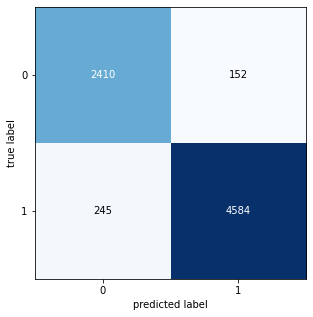

In [ ]:
cm = confusion_matrix(Y.argmax(axis=1), prediction.argmax(axis=1))
plot_confusion_matrix(cm, figsize=(5,5))

In [ ]:
#model.save(f"beto.h5")

## 5. Autoencoder

In [ ]:
# BERT layer
input_word_ids = Input(shape=(max_len,), dtype=int32, name="input_word_ids")
input_mask = Input(shape=(max_len,), dtype=int32, name="input_mask")
segment_ids = Input(shape=(max_len,), dtype=int32, name="segment_ids")

bert_inputs = [input_word_ids, input_mask, segment_ids]

bert_output = TFBertModel.from_pretrained(
           "dccuchile/bert-base-spanish-wwm-uncased", trainable=False, name=f"beto_module"
)(bert_inputs)["pooler_output"]

Some layers from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Add custom layers
encoder = Dense(256, activation='relu')(bert_output)
encoder = Dense(500, activation='sigmoid', name='encoder_1')(encoder)
encoder = Dense(500, activation='sigmoid', name='encoder_2')(encoder)
encoder = Dense(2000, activation='sigmoid', name='encoder_3')(encoder)

# hidden layer
code = Dense(20, activation='sigmoid', name='encoder_hidden')(encoder)  # hidden layer, features are extracted from here

decoder = Dense(2000, activation='sigmoid',  name='decoder_1')(code)
decoder = Dense(500, activation='sigmoid',  name='decoder_2')(decoder)
decoder = Dense(500, activation='sigmoid', name='decoder_3')(decoder)
decoder = Dense(256, name='decoder_4')(decoder)

In [ ]:
encoder = Model(inputs=bert_inputs, outputs=code, name='encoder')

In [ ]:
autoencoder_model = Model(inputs=bert_inputs, outputs=decoder)

autoencoder_model.compile(Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['MSE'])

autoencoder_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 256)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 256)]        0                                            
__________________________________________________________________________________________________
beto_module (TFBertModel)       TFBaseModelOutputWit 109850880   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

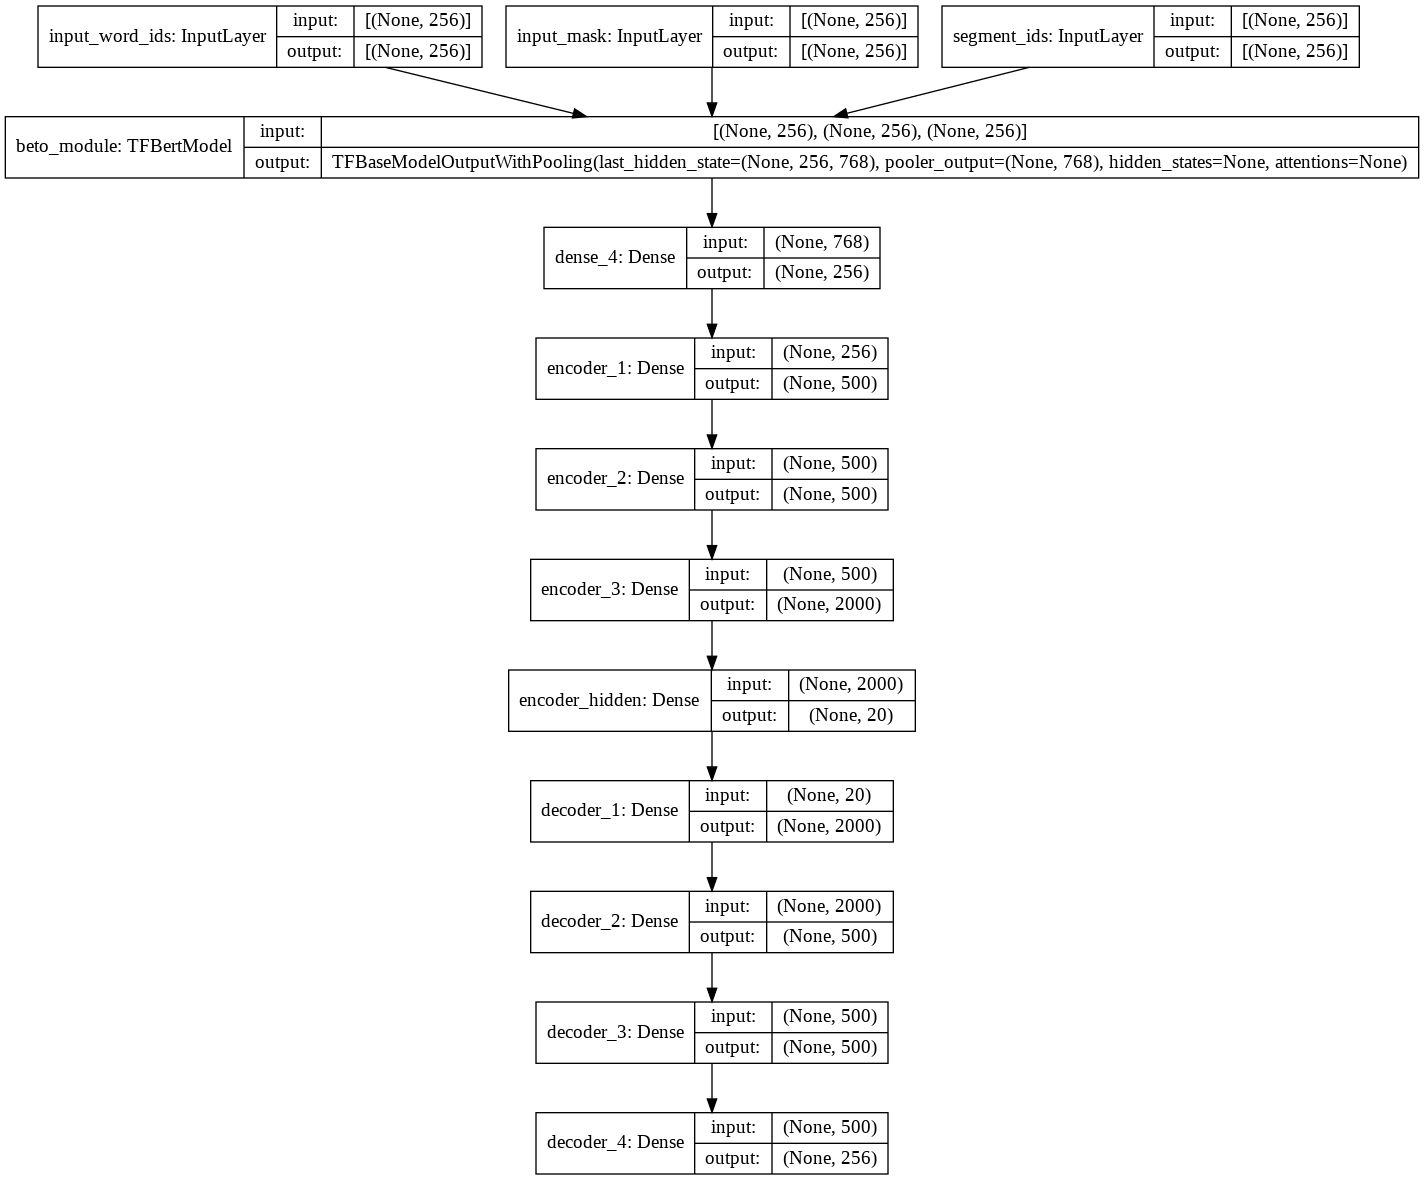

In [ ]:
plot_model(autoencoder_model, to_file='autoencoder.png', show_shapes=True)

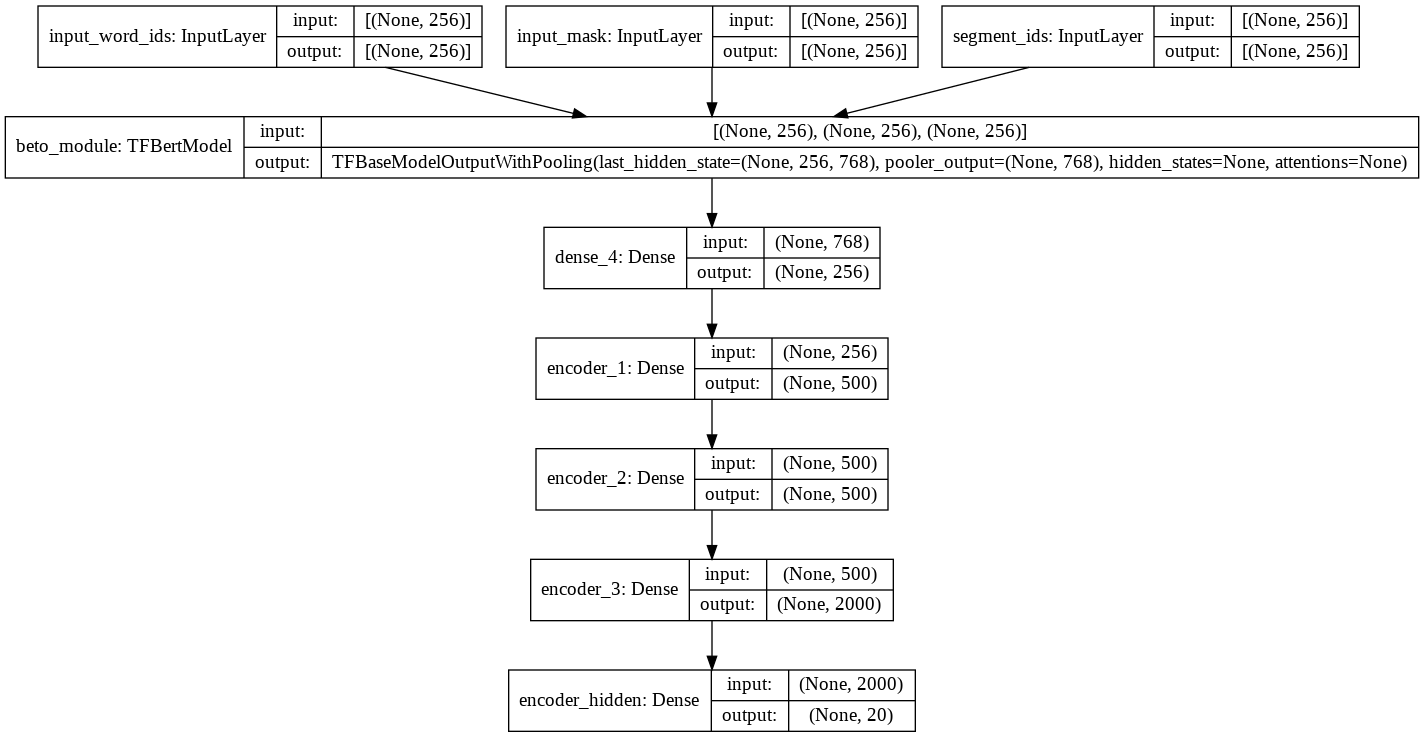

In [ ]:
plot_model(encoder, to_file='encoder.png', show_shapes=True)

In [ ]:
history = autoencoder_model.fit(
    X, X, 
    epochs=3,
    batch_size=32,
    verbose=1
)

Epoch 1/3
231/231 [==============================] - 155s 618ms/step - loss: 892856.9375 - MSE: 7671911.0000
Epoch 2/3
231/231 [==============================] - 148s 641ms/step - loss: 889828.3125 - MSE: 7671915.0000
Epoch 3/3
231/231 [==============================] - 149s 646ms/step - loss: 881733.1875 - MSE: 7671920.5000


In [ ]:
pd.DataFrame(history.history)

,loss,MSE
0,892856.9375,7671911.0
1,889828.3125,7671915.0
2,881733.1875,7671920.5


## 6. Clustering - K-means

In [ ]:
class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.

    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: degrees of freedom parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim,),
                                 initializer='glorot_uniform',
                                 name=self.name)

        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
         Measure the similarity between embedded point z_i and centroid µ_j.
                 q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
                 q_ij can be interpreted as the probability of assigning sample i to cluster j.
                 (i.e., a soft assignment)
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) # Make sure each sample's 10 values add up to 1.
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [ ]:
n_clusters  = 2
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=clustering_layer)

model.compile(optimizer=SGD(0.01, 0.9), loss='kld')
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 256)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 256)]        0                                            
__________________________________________________________________________________________________
beto_module (TFBertModel)       TFBaseModelOutputWit 109850880   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

In [ ]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20)

y_pred = kmeans.fit_predict(encoder.predict(X))

In [ ]:
y_pred_last = np.copy(y_pred)

In [ ]:
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

In [ ]:
# computing an auxiliary target distribution
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

In [ ]:
loss = 0
index = 0
maxiter = 1#8000
update_interval = 1#140
index_array = np.arange(X[0].shape[0])
tol = 0.001 # tolerance threshold to stop training

In [ ]:
nmi = normalized_mutual_info_score
ari = adjusted_rand_score

def acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed
    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`
    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    
    ind = linear_assignment(w.max() - w)
    return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

In [ ]:
batch_size = 32

for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q = model.predict(X, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)
        if Y is not None:
            Y_2 = np.argmax(Y, axis=1)
            acc1 = np.round(acc(Y_2, y_pred), 5)
            nmi1 = np.round(nmi(Y_2, y_pred), 5)
            ari1 = np.round(ari(Y_2, y_pred), 5)
            loss = np.round(loss, 5)
            print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc1, nmi1, ari1), ' ; loss=', loss)

        # check stop criterion - model convergence
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, X[0].shape[0])]
    #loss = model.train_on_batch(x=X[0][idx], y=p[idx])
    index = index + 1 if (index + 1) * batch_size <= X[0].shape[0] else 0

In [ ]:
# Eval.
q = model.predict(X, verbose=1)
p = target_distribution(q)  # update the auxiliary target distribution p

231/231 [==============================] - 129s 558ms/step


In [ ]:
# evaluate the clustering performance
y_pred = q.argmax(1)
if Y is not None:
    acc1 = np.round(acc(np.argmax(Y, axis=1), y_pred), 5)
    nmi1 = np.round(nmi(np.argmax(Y, axis=1), y_pred), 5)
    ari1 = np.round(ari(np.argmax(Y, axis=1), y_pred), 5)
    loss = np.round(loss, 5)
    print('Acc = %.5f, nmi = %.5f, ari = %.5f' % (acc1, nmi1, ari1), ' ; loss=', loss)

Acc = 0.69463, nmi = 0.11770, ari = 0.15115  ; loss= 0


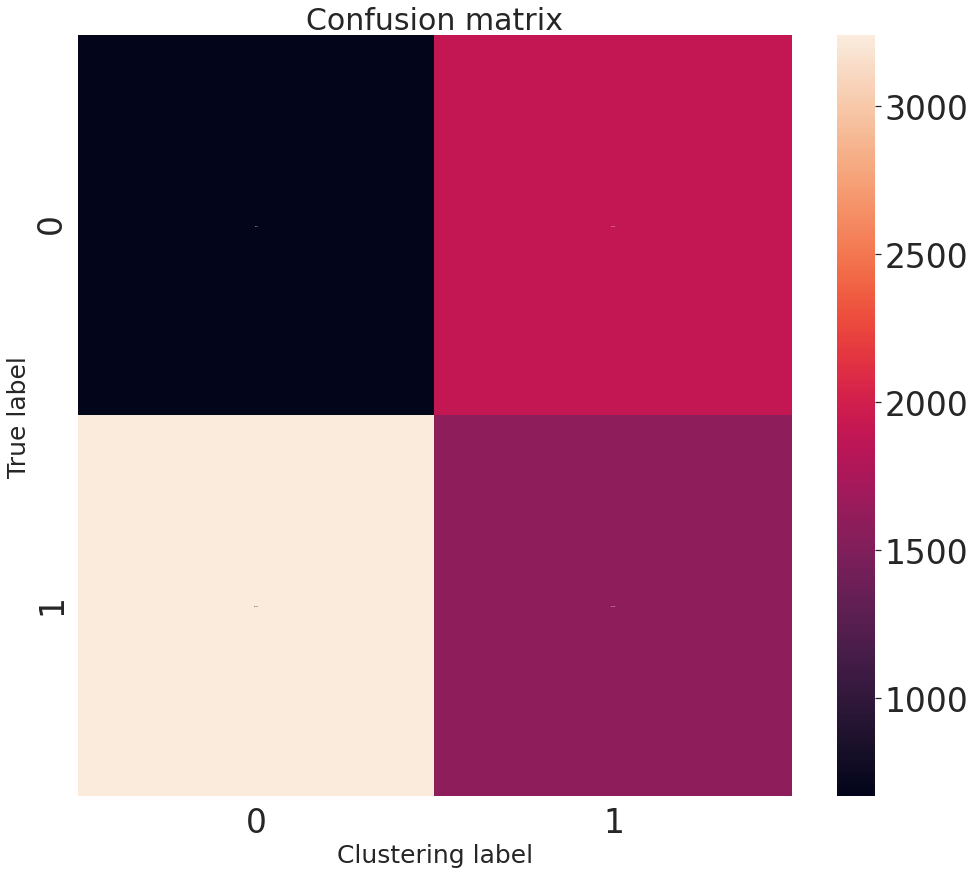

In [ ]:
sns.set(font_scale=3)
confusion_matrip = confusion_matrix(np.argmax(Y, axis=1), y_pred)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrip, annot=True, fmt="d", annot_kws={"size": 2});
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Clustering label', fontsize=25)
plt.show()

## Ecuación Clustering

In [ ]:
# inventemos unas probabilidades asignadas al cluster de 50 textos

def softmax(x):
  return np.exp(x)/np.sum(np.exp(x), axis=1, keepdims=True)

import numpy as np
k = 3
m = 100
temp = np.random.normal(size=(m,k))
q = softmax(temp) ## q vendría en realidad de la función kmeans.predict
q[:10]

array([[0.05565775, 0.32436901, 0.61997324],
       [0.17359063, 0.07342226, 0.75298711],
       [0.58327571, 0.03475428, 0.38197002],
       [0.1909023 , 0.22807682, 0.58102088],
       [0.17315685, 0.77581912, 0.05102402],
       [0.1518572 , 0.52020852, 0.32793429],
       [0.31829164, 0.34949363, 0.33221473],
       [0.38388348, 0.44159813, 0.17451839],
       [0.05295651, 0.53652771, 0.41051578],
       [0.49792176, 0.13276651, 0.36931173]])

In [ ]:
q_squared = q**2
sum_q_clusters = np.sum(q, axis=0)
temp_p = q_squared / sum_q_clusters
p = temp_p / np.sum(temp_p, axis=1, keepdims=True)
p[:10]

array([[0.00602962, 0.24406389, 0.74990649],
       [0.0498173 , 0.01062109, 0.93956161],
       [0.69730274, 0.00295037, 0.2997469 ],
       [0.0834298 , 0.14192122, 0.77464898],
       [0.03998289, 0.95653721, 0.0034799 ],
       [0.05086561, 0.71136841, 0.23776598],
       [0.28338028, 0.40717755, 0.30944217],
       [0.35917005, 0.56642425, 0.0744057 ],
       [0.00544769, 0.66641451, 0.32813779],
       [0.61118871, 0.05178647, 0.33702482]])